In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import torchattacks
from matplotlib import pyplot as plt
from tqdm import tqdm
from torchvision.models import resnet50
from resnet import *
from rankings import *

from wideresnet import WideResNet

imagenet ='imagenet'
cifar = 'cifar'
architecture = 'architecture' #requires wide resnet models to run
resized = 'resized'
compressed = 'compressed'
none = 'none'
PGD = 'PGD'

dataset = cifar
scenario = none
attack = PGD


In [2]:
!pip install gdown

In [3]:
import gdown

url = 'https://drive.google.com/u/0/uc?id=1xu2WQCJ3hx--9lWDF4S9JZQ4OUrGQLEq&export=download'
output = 'models.zip'
gdown.download(url, output, quiet=True) 

'models.zip'

In [4]:
url = 'https://drive.google.com/u/0/uc?id=1gz3sgPUZZicvJn6psy_TZLSTjWR2pP7I&export=download'
output = 'wide_models.zip'
gdown.download(url, output, quiet=True) 


'wide_models.zip'

In [5]:
!unzip -o models.zip -d ./
!unzip -o wide_models.zip -d ./


Archive:  models.zip
  inflating: ./resnet18/model_val_1.pth  
  inflating: ./resnet18/model_val_2.pth  
  inflating: ./resnet18/model_val_3.pth  
  inflating: ./resnet18/model_val_4.pth  
  inflating: ./resnet18/model_val_5.pth  
  inflating: ./resnet18/model_val_6.pth  
  inflating: ./resnet18/model_val_7.pth  
  inflating: ./resnet18/model_val_8.pth  
  inflating: ./resnet18/model_val_9.pth  
  inflating: ./resnet18/model_val10.pth  
  inflating: ./resnet18/model_val11.pth  
  inflating: ./resnet18/model_val13.pth  
Archive:  wide_models.zip
  inflating: ./wideresnet/model_val_1.pth  
  inflating: ./wideresnet/model_val_2.pth  
  inflating: ./wideresnet/model_val_3.pth  
  inflating: ./wideresnet/model_val_4.pth  
  inflating: ./wideresnet/model_val_5.pth  
  inflating: ./wideresnet/model_val_6.pth  
  inflating: ./wideresnet/model_val_7.pth  
  inflating: ./wideresnet/model_val_8.pth  


In [7]:

if dataset==cifar:
    mu = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1).cuda()
    std = torch.tensor([0.2471, 0.2435, 0.2616]).view(3,1,1).cuda()
    
else:    
    mu = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).cuda()
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).cuda()

def normalize(X):
    return (X - mu)/std

class normalized_net(nn.Module):
    def __init__(self, net):
        super(normalized_net, self).__init__()
        self.net = net
        
    def forward(self, x):
        output = self.net(normalize(x))
        return output

if dataset == cifar:
    batch_size = 256
    test_transform = transforms.Compose(
        [transforms.ToTensor(), 
        ])
    cifar10_test = torchvision.datasets.CIFAR10(root='data/cifar', train=False,
                                                download=True, transform=test_transform)
    testloader = torch.utils.data.DataLoader(cifar10_test, batch_size=batch_size,
                                             shuffle=False, num_workers=4)

else:
    batch_size = 64 
    test_transforms =  transforms.Compose([transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor()])
    #only on first run
    imagenet_data = torchvision.datasets.ImageNet('imagenet/',split='val',transform=test_transforms)
    
    #imagenet_data = torch.load('imagenet_dataset_155131872_k=1')
    testloader = torch.utils.data.DataLoader(imagenet_data, batch_size=batch_size,
                                             shuffle=False, num_workers=4)

if dataset==cifar:
    dataset_data = cifar10_test
else:
    dataset_data = imagenet_data

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
cross_entropy = nn.CrossEntropyLoss()

In [10]:
lower = torch.Tensor([0, 0, 0])
upper = torch.Tensor([1, 1, 1])

def make_gen_adversarial_batch(net, eps=8/255 , alpha=1/255,bound=0,iters=20):
    def gen_adversarial_batch(sample, labels):
        ce = nn.CrossEntropyLoss()
        labels = labels.cuda()
        loss_func = nn.CrossEntropyLoss()
        ori_sample = sample.detach().cuda()
        for i in range(iters):
            sample = torch.autograd.Variable(sample.cuda(), requires_grad=True)
            output = net(sample)
            loss = ce(output,labels)
            loss.backward()
            adv_images = sample + alpha*sample.grad.sign()
            eta = torch.clamp(adv_images - ori_sample, min=-eps, max=eps)
            sample = (ori_sample + eta).detach()
            for dim in [0, 1, 2]:
                sample[:, dim, :, :] = torch.clamp(sample[:, dim, :, :],
                                                   lower[dim], upper[dim])
        return sample
    return gen_adversarial_batch


def clamp(X, lower_limit, upper_limit):
    return torch.max(torch.min(X, upper_limit), lower_limit)


def create_adv_loader(net, loader, eps,alpha=1/255,iters=20, attack = 'PGD', generate_new=False):
    net.cuda()
    net.eval()
    adv_samples = []
    labels_new = []
    correct_benign_samples = []
    correct_benign_labels = []
    if dataset==cifar or generate_new:
        if attack=='PGD':
            atk = torchattacks.PGD(net,random_start=False, eps=eps,alpha=alpha,steps=iters)
        elif attack=='FGSM':
            atk = torchattacks.FGSM(net, eps=eps)
        elif attack=='MIFGSM':
            atk = torchattacks.MIFGSM(net, eps=eps,alpha=alpha,steps=iters)
        elif attack=='DIFGSM':
            atk = torchattacks.DIFGSM(net, eps=eps,alpha=alpha,steps=iters)
        elif attack=='TIFGSM':
            atk = torchattacks.TIFGSM(net, eps=eps,alpha=alpha,steps=iters)
        elif attack=='FAB':
            atk = torchattacks.FAB(net, eps=eps)
        print('Start attacking')
        for batch_idx, (inputs, labels) in enumerate(tqdm(loader)):
            adv_inputs = atk(inputs, labels)
            adv_samples.append(adv_inputs.to('cpu'))
            labels_new.append(labels.to('cpu'))

        adv_samples = torch.cat(adv_samples).to('cpu')
        labels_new = torch.cat(labels_new).to('cpu')

    else:
        labels_new = torch.load(f'imagenet_labels_new_{iters}_iters')
        adv_samples = torch.load(f'imagenet_adv_samples_{iters}_iters')
        
    adv_dataset = torch.utils.data.TensorDataset(adv_samples, labels_new)
    adv_loader = torch.utils.data.DataLoader(adv_dataset, batch_size=batch_size,
                                             shuffle=False, num_workers=4)
    net.to('cpu')
    return adv_loader

    

In [11]:
img = next(iter(testloader))[0][0]

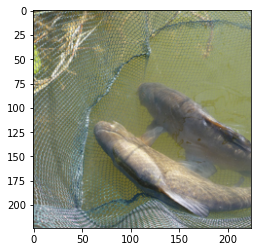

In [12]:
plt.imshow(img.permute([1,2,0]))

In [13]:
def test(net,testloader):
    net.eval()
    net.cuda()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = cross_entropy(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    test_acc = correct/total
    test_loss = test_loss/batch_idx
    net.cpu()
    return test_acc, test_loss

In [14]:
from torch.utils.data.sampler import Sampler
class filtered_dataset(Sampler):
    def __init__(self, mask):
        self.mask = mask.nonzero().squeeze()

    def __iter__(self):
        for indc in mask:
            yield indc

    def __len__(self):
        return len(self.mask)
    
def filter_dataset_according_to_model_prediciton(net, loader,collect_correct=False):
    samples_to_collect = []
    labels_to_collect = []
    net.cuda()
    net.eval()
    mask_all = []
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(tqdm(loader)):
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            if collect_correct:
                mask = predicted.eq(labels)
            else:
                mask = ~predicted.eq(labels)
            mask_all.append(mask)
        mask_all = torch.cat(mask_all)
        new_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset_data,mask_all.nonzero().squeeze().detach().cpu().tolist()) , batch_size=batch_size,
                                                 shuffle=False, num_workers=4)
        net.cpu()
    return new_loader

## Benign Analysis

In [15]:
if dataset==cifar:
    path_vanilla = './resnet18', 'vanilla'
    
else:
    path_vanilla = './ResNet50-imagenet-full', 'vanilla'


    

path_vanila,model_name = path_vanilla

if dataset==cifar:
    model_class = ResNet18
else:
    model_class = resnet50


In [16]:
from huggingface_hub import hf_hub_download
seeds = [ '155131872', '1909114418', '1983924597', '207214159', '2165418652', '252421721', '306425915', '3104512310', '314297134', '91408020']
nets = []
nets_scenario = []
if dataset==cifar:
    for filename in os.listdir(path_vanila):
        if filename.endswith(".pth"):
            net = model_class()
            #print(filename)
            net = nn.DataParallel(net)
            checkpint = torch.load(f'./{path_vanila}/{filename}')
            net.load_state_dict(checkpint['state_dict'])
            net = normalized_net(net)
            net.eval()
            nets.append(net)
    

    wide_path = './wideresnet'
    
    for filename in os.listdir(wide_path):
        if filename.endswith(".pth"):
            net = WideResNet()
            net = nn.DataParallel(net)
            checkpint = torch.load(f'./{wide_path}/{filename}')
            net.load_state_dict(checkpint['state_dict'])
            net = normalized_net(net)
            net.eval()
            nets_scenario.append(net)
else:
    for seed in seeds:
        filename = f'seed-{seed}_step-450359.pt'
        path = hf_hub_download(repo_id=f"nghosh/ResNet50-imagenet-full", filename=filename)
        state_dict = torch.load(path)
        net = model_class()
        net.load_state_dict(state_dict)
        net = nn.DataParallel(net)
        net = normalized_net(net)
        net.eval()
        nets.append(net)
    model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
    model = normalized_net(model)
    nets_scenario.append(net)
    trained_model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=False)
    checkpoint = torch.load('models_wideresnet_imagenet/checkpoint2.pth.tar')
    trained_model = nn.DataParallel(trained_model)

    trained_model.load_state_dict(checkpoint['state_dict'])
    trained_model = normalized_net(trained_model)
    nets_scenario.append(trained_model)
    



Using cache found in /home/moshe5/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/moshe5/.cache/torch/hub/pytorch_vision_v0.10.0


In [17]:
def get_labels(loader):
    all_labels=[]
    #all_samples = []
    for _, labels in loader:
        all_labels.append(labels)
    all_labels = torch.cat(all_labels)
    #all_samples = torch.cat(all_samples)

    return all_labels

In [18]:
if dataset==cifar:
    testloader = filter_dataset_according_to_model_prediciton(nets[0],testloader,collect_correct=True)
else:
    testloader = filter_dataset_according_to_model_prediciton(nets[0],testloader,collect_correct=True)
    torch.save(testloader.dataset, 'imagenet_dataset_155131872_k=1')

100%|██████████| 782/782 [06:04<00:00,  2.15it/s]


In [19]:
len(testloader.dataset)

37717

In [20]:
if dataset==cifar:
    pert_size = 4/255
    iters=40
    k=1
    net,loader,eps,alpha =  nets[0], testloader, pert_size, 1/255
else:
    pert_size = 1/255
    iters=7
    k=1
    net,loader,eps,alpha =  nets[0], testloader, pert_size, 0.25/255

Note the accuracy of  the surrogate model (f') is 100%

In [21]:
test(nets[0],testloader)

100%|██████████| 590/590 [02:05<00:00,  4.71it/s]


(1.0, 0.1722839394369256)

In [22]:

if dataset==imagenet:
    net = nets[0]
    net.cuda()

    adv_samples = []
    labels_new = []
    first=True
    atk = torchattacks.PGD(net, eps=eps,alpha=alpha,steps=iters)
    for batch_idx, (inputs, labels) in enumerate(tqdm(loader)):
        adv_inputs = atk(inputs, labels)
        if first:
            adv_samples = adv_inputs.to('cpu')
            labels_new = labels.to('cpu')
            first=False
        else:
            adv_samples = torch.cat([adv_samples,adv_inputs.to('cpu')])
            labels_new = torch.cat([labels_new,labels.to('cpu')])

    torch.save(labels_new,f'imagenet_labels_new_{iters}_iters_eps_{eps}_{attack}')
    torch.save(adv_samples,f'imagenet_adv_samples_{iters}_iters_eps_{eps}_{attack}')
    labels_new = torch.load(f'imagenet_labels_new_{iters}_iters_eps_{eps}_{attack}')
    adv_samples = torch.load(f'imagenet_adv_samples_{iters}_iters_eps_{eps}_{attack}')
    adv_dataset = torch.utils.data.TensorDataset(adv_samples, labels_new)
    adv_data = torch.utils.data.DataLoader(adv_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

100%|██████████| 590/590 [44:58<00:00,  4.57s/it]


In [23]:
if dataset==imagenet:
    #Requires the blocks above
    labels_new = torch.load(f'imagenet_labels_new_{iters}_iters_eps_{eps}_{attack}')
    adv_samples = torch.load(f'imagenet_adv_samples_{iters}_iters_eps_{eps}_{attack}')
    adv_dataset = torch.utils.data.TensorDataset(adv_samples, labels_new)
    adv_data = torch.utils.data.DataLoader(adv_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)
else:
    adv_data = create_adv_loader(nets[0], testloader, eps,alpha=alpha,iters=iters, attack = attack)

In [24]:
test(nets[0],adv_data)

100%|██████████| 590/590 [01:08<00:00,  8.64it/s]


(0.015589787098655779, 15.75004034576675)

In [25]:
test(nets[5],adv_data)

100%|██████████| 590/590 [01:07<00:00,  8.69it/s]


(0.8179335578121272, 0.5987119673164673)

In [26]:
import cv2
def data_corrupted_iter(corruption_size,loader):
    for inputs,labels in loader:
        inputs = inputs+corruption_size*torch.randn(*(inputs.shape))
        inputs = torch.clamp(inputs, min=0, max=255)
        yield inputs,labels
        
def data_compressed_iter(loader):
    
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 90]
    for inputs,labels in loader:
        compressed=[]
        for inpt in inputs:
            img = (inpt.cpu().numpy()*255).astype(np.uint8).transpose([1,2,0])
            result, encimg = cv2.imencode('.jpg', img, encode_param)
            decimg = cv2.imdecode(encimg, 1)
            compressed.append(torch.Tensor(decimg.transpose(2,0,1))/255)
        compressed = torch.stack(compressed,0)
        yield compressed,labels

def data_resized_iter(loader,dim=(31,31),ori_dim=(32,32)):
    for inputs,labels in loader:
        compressed=[]
        for inpt in inputs:
            img = (cv2.resize(cv2.resize(inpt.permute([1,2,0]).detach().cpu().numpy(), dim),ori_dim))
            compressed.append(torch.Tensor(img.transpose(2,0,1)))
        compressed = torch.stack(compressed,0)
        yield compressed,labels
        
if scenario=='compressed':
    adv_data_scenario = lambda: data_compressed_iter(adv_data)
    testloader_scenario = lambda: data_compressed_iter(testloader)
elif scenario=='resized':
    if dataset==cifar:
        adv_data_scenario = lambda: data_resized_iter(adv_data)
        testloader_scenario = lambda: data_resized_iter(testloader)
    else:
        adv_data_scenario = lambda: data_resized_iter(adv_data,(200,200),(224,224))
        testloader_scenario = lambda: data_resized_iter(testloader,(200,200),(224,224))
else:
    adv_data_scenario = lambda: adv_data
    

In [27]:
def get_correctness(net,loader,k=1):
    net.cuda()
    correctness = []
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(tqdm(loader)):
            inputs, labels = inputs.to(device),  labels.to(device)
            outputs = net(inputs)
            top_prob = outputs.topk(k,dim=1).indices
            prediction = torch.zeros(outputs.shape[0])
            for i in range(k):
                predicted = top_prob[:,i].eq(labels).cpu()
                corrects = (predicted==True)
                prediction = prediction + (corrects)
            correctness.append(prediction)
        correctness = torch.cat(correctness)
        net.cpu()
    return correctness

In [28]:
correctnesses  = []
for net in nets[4:]:
    correctnesses.append(get_correctness(net,adv_data,k))
correctnesses_scenario  = []
if scenario=='architecture':
    print('architecture')
    for net in nets_scenario[3:]:
        correctnesses_scenario.append(get_correctness(net,adv_data,k))
else:
    for net in nets[4:]:
        correctnesses_scenario.append(get_correctness(net,adv_data_scenario(),k))


100%|██████████| 590/590 [01:07<00:00,  8.71it/s]
590it [02:03,  4.76it/s]
590it [02:03,  4.76it/s]
590it [02:03,  4.77it/s]
590it [02:03,  4.79it/s]
590it [01:55,  5.13it/s]
590it [02:03,  4.76it/s]


In [29]:
def get_precision(correctness,order,k):
    return correctness[order][:k].sum()/k 

In [30]:
def confidence_ranking(net,adv_loader):
    net.cuda()
    all_probs = []
    for batch_idx, (inputs, labels) in enumerate(adv_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        outputs = F.softmax(outputs,1)
        correct_confidence = outputs.gather(1,labels.unsqueeze(1)).squeeze().detach().cpu()
        all_probs.append(correct_confidence)
    all_probs = torch.cat(all_probs).cpu()
    net.cpu()
    return 0, all_probs

# Ranking

In [31]:
with torch.no_grad():
    nets[0].cuda()
    apriori_ranks = list(confidence_ranking(nets[0],testloader)[1])
    nets[0].cpu()
    multi_ranks = []
    for net in nets[1:4]:
        net.cuda()
        multi_ranks.append(np.array(confidence_ranking(net,adv_data)[1]))
        net.cpu()
    postriori_rank = list(np.array(multi_ranks).sum(0))
    multi_ranks = []
    if scenario=='architecture':
        for net in nets_scenario[:3]:
            net.cuda()
            multi_ranks.append(np.array(confidence_ranking(net,adv_data)[1]))
            net.cpu()
    else:
        for net in nets[1:4]:
            net.cuda()
            if scenario=='compressed' or scenario =='resized':
                multi_ranks.append(np.array(confidence_ranking(net,adv_data_scenario())[1]))
            else:
                multi_ranks.append(np.array(confidence_ranking(net,adv_data)[1]))
            net.cpu()
    post_process_rank = list(np.array(multi_ranks).sum(0))

In [32]:
def noise_pert_ranking(net,loader,pert_size):
    net.cuda()
    ranking = []
    for batch_idx, (inputs, labels) in enumerate(tqdm(loader)):
        pred_corrects = []
        inputs, labels = inputs.to(device), labels.to(device)

        for i in range(20):
            noise = torch.normal(0.0,1.0,inputs.shape).cuda()*(16/255) 
            inputs_noised= inputs+noise
            pred = net(inputs_noised).max(1)[1]
            pred_correct = pred.eq(labels).cpu()
            pred_corrects.append(pred_correct)
        ranking += (torch.stack(pred_corrects).float().mean(0)).cpu()
    net.cpu()
    return 0,ranking

In [33]:
noise_pert_rank = noise_pert_ranking(nets[0],testloader,pert_size)


100%|██████████| 590/590 [36:58<00:00,  3.76s/it]


In [34]:
random_list = list(range(len(testloader.dataset)))
np.random.shuffle(random_list)
true_ranking  = np.mean([list(correctness.float()) for correctness in correctnesses_scenario],0)

In [35]:
def get_precision_mat(ranks):
    top_k = len(testloader.dataset)
    precisions_mat = []
    sorted_ranks = []
    for rank in ranks:
        print('i')
        rank = list(rank)
        order = np.argsort(rank).tolist() 
        sorted_ranks.append(order)
    correctnesses_to_use = correctnesses_scenario
    for correctness in correctnesses_to_use:
        precisions_for_rank = []
        for order in sorted_ranks:
            precisions_for_rank.append([get_precision(correctness,order,k) for k in range(0,top_k,int(top_k/1000))])
        precisions_mat.append(precisions_for_rank)
    precisions_mat = np.array(precisions_mat)[:,:,1:]
    precisions_mat_std = precisions_mat.std(0) 
    
    precisions_mat_mean = 1 - precisions_mat.mean(0)
    precisions_mat_up =  (precisions_mat_mean - precisions_mat_std )
    precisions_mat_down =  (precisions_mat_mean + precisions_mat_std)
    return precisions_mat_mean, precisions_mat_up, precisions_mat_down


In [36]:
precisions = get_precision_mat([apriori_ranks,postriori_rank,post_process_rank,random_list,true_ranking,noise_pert_rank[1]])

i
i
i
i
i
i


In [37]:
if dataset==cifar:
    x_labels  = [0,1000,2000,3000,4000,5000,6000,7000,8000,9426]
    x_ticks = [label/9 for label in x_labels[:-1]] + [1047]
else:
    x_labels  = [0,6000,12000,18000,24000,30000,37729]
    x_ticks = [label/36 for label in x_labels[:-1]] + [1019]

In [38]:
plt.style.use('ggplot')



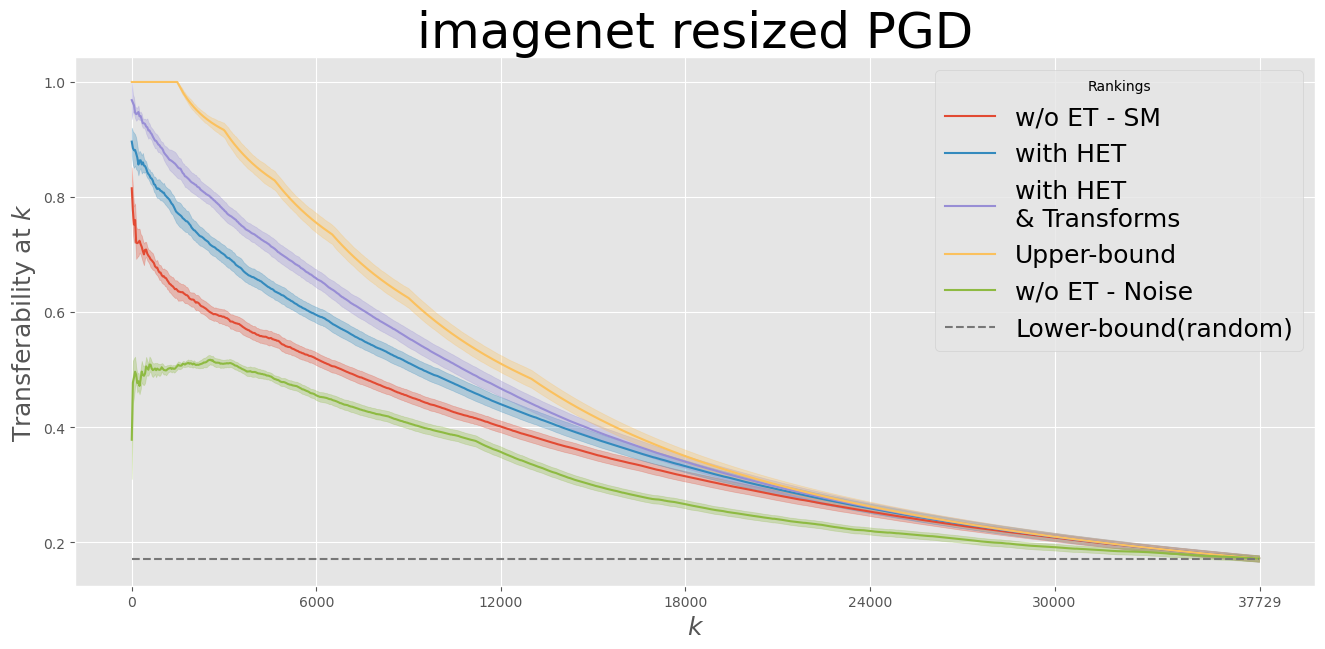

In [42]:
#precisions
natural=scenario=='none'
plt.figure(figsize=[16,7],dpi=100)
rankings_labels = ['w/o ET - SM','with HET','with HET\n& Transforms', 
                       'Lower-bound(random)','Upper-bound','w/o ET - Noise']
colors = ['C0','C1', 'C2', 'C3','C4','C5']
for precision_k,fill_up,fill_down,label,color in zip(precisions[0],precisions[1],precisions[2], rankings_labels,colors):
    if natural and label=='with HET\n& Transforms' or label=='Lower-bound(random)' :
        continue
    base_line = plt.plot(precision_k,label=label,color=color)
    plt.fill_between(list(range(0,len(precision_k))), fill_down, fill_up, color=base_line[0].get_color(),
                 alpha=0.3)
locs,labels = plt.xticks()
plt.plot([precision_k[-1]]*len(precision_k),label='Lower-bound(random)',color='C3',ls='--')
plt.xticks(x_ticks,x_labels)
plt.title(f'{dataset} {scenario} {attack}',size=36)
plt.ylabel('Transferability at $k$',size=18)
plt.xlabel('$k$',size=18)
plt.legend(title="Rankings",fontsize=18)
plt.savefig(f"Transferabilty@k_{dataset}_{scenario}_{attack}.png")
#fig.tight_layout()

#fig.savefig("transferability.pdf", bbox_inches='tight')
plt.show()
